In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time,datetime

today = datetime.date.today()

from datetime import date,timedelta
import jpholiday

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

import os, shutil, requests,zipfile

# 厚生労働省のHPからCSVをDL
https://www.mhlw.go.jp/stf/covid-19/open-data.html

# Google モビリティからZIPをDL
https://www.google.com/covid19/mobility/

# 気象庁から手作業で気温・湿度DL
https://www.data.jma.go.jp/gmd/risk/obsdl/index.php

In [2]:
''' 厚生労働省データ '''
positive = 'https://www.mhlw.go.jp/content/pcr_positive_daily.csv'
pcr_test = 'https://www.mhlw.go.jp/content/pcr_tested_daily.csv'
in_hospital = 'https://www.mhlw.go.jp/content/cases_total.csv'
recovery_num = 'https://www.mhlw.go.jp/content/recovery_total.csv'
death_num ='https://www.mhlw.go.jp/content/death_total.csv'

''' Google data '''
url = 'https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip'
file_name = os.path.basename(url)
res = requests.get(url, stream=True)
if res.status_code == 200:
    with open('./zip/'+file_name, 'wb') as file:
        res.raw.decode_content = True
        shutil.copyfileobj(res.raw, file)
        
with zipfile.ZipFile('./zip/'+file_name) as existing_zip:
    #print(existing_zip.namelist())
    existing_zip.extract('2020_JP_Region_Mobility_Report.csv','./csv/')


temp = pd.read_csv('./csv/data.csv',encoding="shift-jis",header=2) #https://www.data.jma.go.jp/gmd/risk/obsdl/index.php
temp = temp.iloc[1:,[0,1,4]] #余計な行列を削除

pos = pd.read_csv(positive)
pcr = pd.read_csv(pcr_test)
hosp = pd.read_csv(in_hospital)
rec = pd.read_csv(recovery_num)
dead = pd.read_csv(death_num)

mb = pd.read_csv('./csv/2020_JP_Region_Mobility_Report.csv')
mb = mb[mb['sub_region_1']=='Tokyo']
mb = mb.iloc[:,[7,8,11]]

pos.columns = ['Date','Positive']
pcr.columns = ['Date','Test']
hosp.columns = ['Date','Severe']
rec.columns = ['Date','Recovery']
dead.columns = ['Date','Death']

mb.columns = ['Date','RecRate','TrainRate']
temp.columns = ['Date','Humidity','Temparature']

pos['Date'] = pd.to_datetime(pos['Date'])
pcr['Date'] = pd.to_datetime(pcr['Date'])
hosp['Date'] = pd.to_datetime(hosp['Date'])
rec['Date'] = pd.to_datetime(rec['Date'])
dead['Date'] = pd.to_datetime(dead['Date'])

mb['Date'] = pd.to_datetime(mb['Date'])
temp['Date'] = pd.to_datetime(temp['Date'])

pos = pos.set_index('Date')
pcr = pcr.set_index('Date')
hosp = hosp.set_index('Date')
rec = rec.set_index('Date')
dead = dead.set_index('Date')


mb = mb.set_index('Date')
temp = temp.set_index('Date')

df = pd.concat([pos,pcr],axis=1)
df = pd.concat([df,hosp],axis=1)
df = pd.concat([df,rec],axis=1)
df = pd.concat([df,dead],axis=1)
df = pd.concat([df,mb],axis=1)
df = pd.concat([df,temp],axis=1)

# 乗車率の欠損値補完
# 祝日・曜日フラグ

In [3]:
df

,Positive,Test,Severe,Recovery,Death,RecRate,TrainRate,Humidity,Temparature
Date,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5,32.0
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.2,40.0
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,42.0
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2,33.0
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.4,34.0
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,31.0
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.7,49.0
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,89.0


In [4]:
df2 = df.copy()
df2=df2.interpolate()
df2.fillna(0,inplace=True)

df2['is_holiday'] = df2.index.map(jpholiday.is_holiday).astype(int)
df2['dayofweek'] = df2.index.dayofweek
df2 = df2.iloc[1:,:] #一行目Nanが入るのを削除　要検証

# 60日前のラグ特徴量作成

In [5]:
df3 = df2.copy()
df3['Date'] = df3.index + timedelta(days=60)
df3 = df3.set_index('Date')
df3.columns = ['Positive_lag60','Test_lag60','Severe_lag60','Recovery_lag60',
               'Dead_lag60','RecRate_lag60','TrainRate_lag60','Humidity_lag60',
               'Temparature_lag60','is_holiday_lag60','dayofweek_lag60']

#df3['Positive']= df2['Positive']
df3 =df3.fillna(0)

# 45日前のラグ特徴量作成

In [6]:
df3

,Positive_lag60,Test_lag60,Severe_lag60,Recovery_lag60,Dead_lag60,RecRate_lag60,TrainRate_lag60,Humidity_lag60,Temparature_lag60,is_holiday_lag60,dayofweek_lag60
Date,,,,,,,,,,,
2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.5,32.0,1,2.0
2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,40.0,0,3.0
2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.1,42.0,0,4.0
2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.2,33.0,0,5.0
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,34.0,0,6.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,31.0,0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.7,49.0,0,1.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.2,89.0,0,2.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.6,30.0,0,3.0


In [7]:
df5 = df2.copy()
df5['Date'] = df5.index + timedelta(days=45)
df5 = df5.set_index('Date')
df5.columns = ['Positive_lag45','Test_lag45','Severe_lag45','Recovery_lag45',
               'Dead_lag45','RecRate_lag45','TrainRate_lag45','Humidity_lag45',
               'Temparature_lag45','is_holiday_lag45','dayofweek_lag45']

df5['Positive']= df2['Positive']
#df5 =df5.fillna(0)

In [8]:
df5

,Positive_lag45,Test_lag45,Severe_lag45,Recovery_lag45,Dead_lag45,RecRate_lag45,TrainRate_lag45,Humidity_lag45,Temparature_lag45,is_holiday_lag45,dayofweek_lag45,Positive
Date,,,,,,,,,,,,
2020-02-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.5,32.0,1,2.0,12.0
2020-02-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,40.0,0,3.0,6.0
2020-02-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.1,42.0,0,4.0,7.0
2020-02-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.2,33.0,0,5.0,7.0
2020-02-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,34.0,0,6.0,10.0
2020-02-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,31.0,0,0.0,9.0
2020-02-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.7,49.0,0,1.0,11.0
2020-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.2,89.0,0,2.0,27.0
2020-02-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.6,30.0,0,3.0,12.0


In [9]:
df6 = pd.concat([df3,df5],axis=1)

In [10]:
df6

,Positive_lag60,Test_lag60,Severe_lag60,Recovery_lag60,Dead_lag60,RecRate_lag60,TrainRate_lag60,Humidity_lag60,Temparature_lag60,is_holiday_lag60,dayofweek_lag60,Positive_lag45,Test_lag45,Severe_lag45,Recovery_lag45,Dead_lag45,RecRate_lag45,TrainRate_lag45,Humidity_lag45,Temparature_lag45,is_holiday_lag45,dayofweek_lag45,Positive
Date,,,,,,,,,,,,,,,,,,,,,,,
2020-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.5,32.0,1.0,2.0,12.0
2020-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,40.0,0.0,3.0,6.0
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.1,42.0,0.0,4.0,7.0
2020-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.2,33.0,0.0,5.0,7.0
2020-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,34.0,0.0,6.0,10.0
2020-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,31.0,0.0,0.0,9.0
2020-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.7,49.0,0.0,1.0,11.0
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.2,89.0,0.0,2.0,27.0
2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.6,30.0,0.0,3.0,12.0


In [11]:
df7 = df6.iloc[15:-15,:] # 前後15日分（60−45）の欠損を削除

In [12]:
df7

,Positive_lag60,Test_lag60,Severe_lag60,Recovery_lag60,Dead_lag60,RecRate_lag60,TrainRate_lag60,Humidity_lag60,Temparature_lag60,is_holiday_lag60,dayofweek_lag60,Positive_lag45,Test_lag45,Severe_lag45,Recovery_lag45,Dead_lag45,RecRate_lag45,TrainRate_lag45,Humidity_lag45,Temparature_lag45,is_holiday_lag45,dayofweek_lag45,Positive
Date,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.5,32.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.7,30.0,0.0,3.0,15.0
2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.2,40.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.3,42.0,0.0,4.0,14.0
2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.1,42.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.8,59.0,0.0,5.0,16.0
2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.2,33.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.5,36.0,0.0,6.0,33.0
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,34.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,32.0,0.0,0.0,31.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.4,29.0,0.0,1.0,59.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.7,49.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.9,43.0,0.0,2.0,47.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.2,89.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.1,64.0,0.0,3.0,33.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.6,30.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.9,44.0,0.0,4.0,26.0


# StandardScalerでグラフ描画

In [13]:
scaler = StandardScaler()
df4 = scaler.fit_transform(df2)
df4 = pd.DataFrame(df4)
df4.columns = df2.columns
df4.index = df2.index

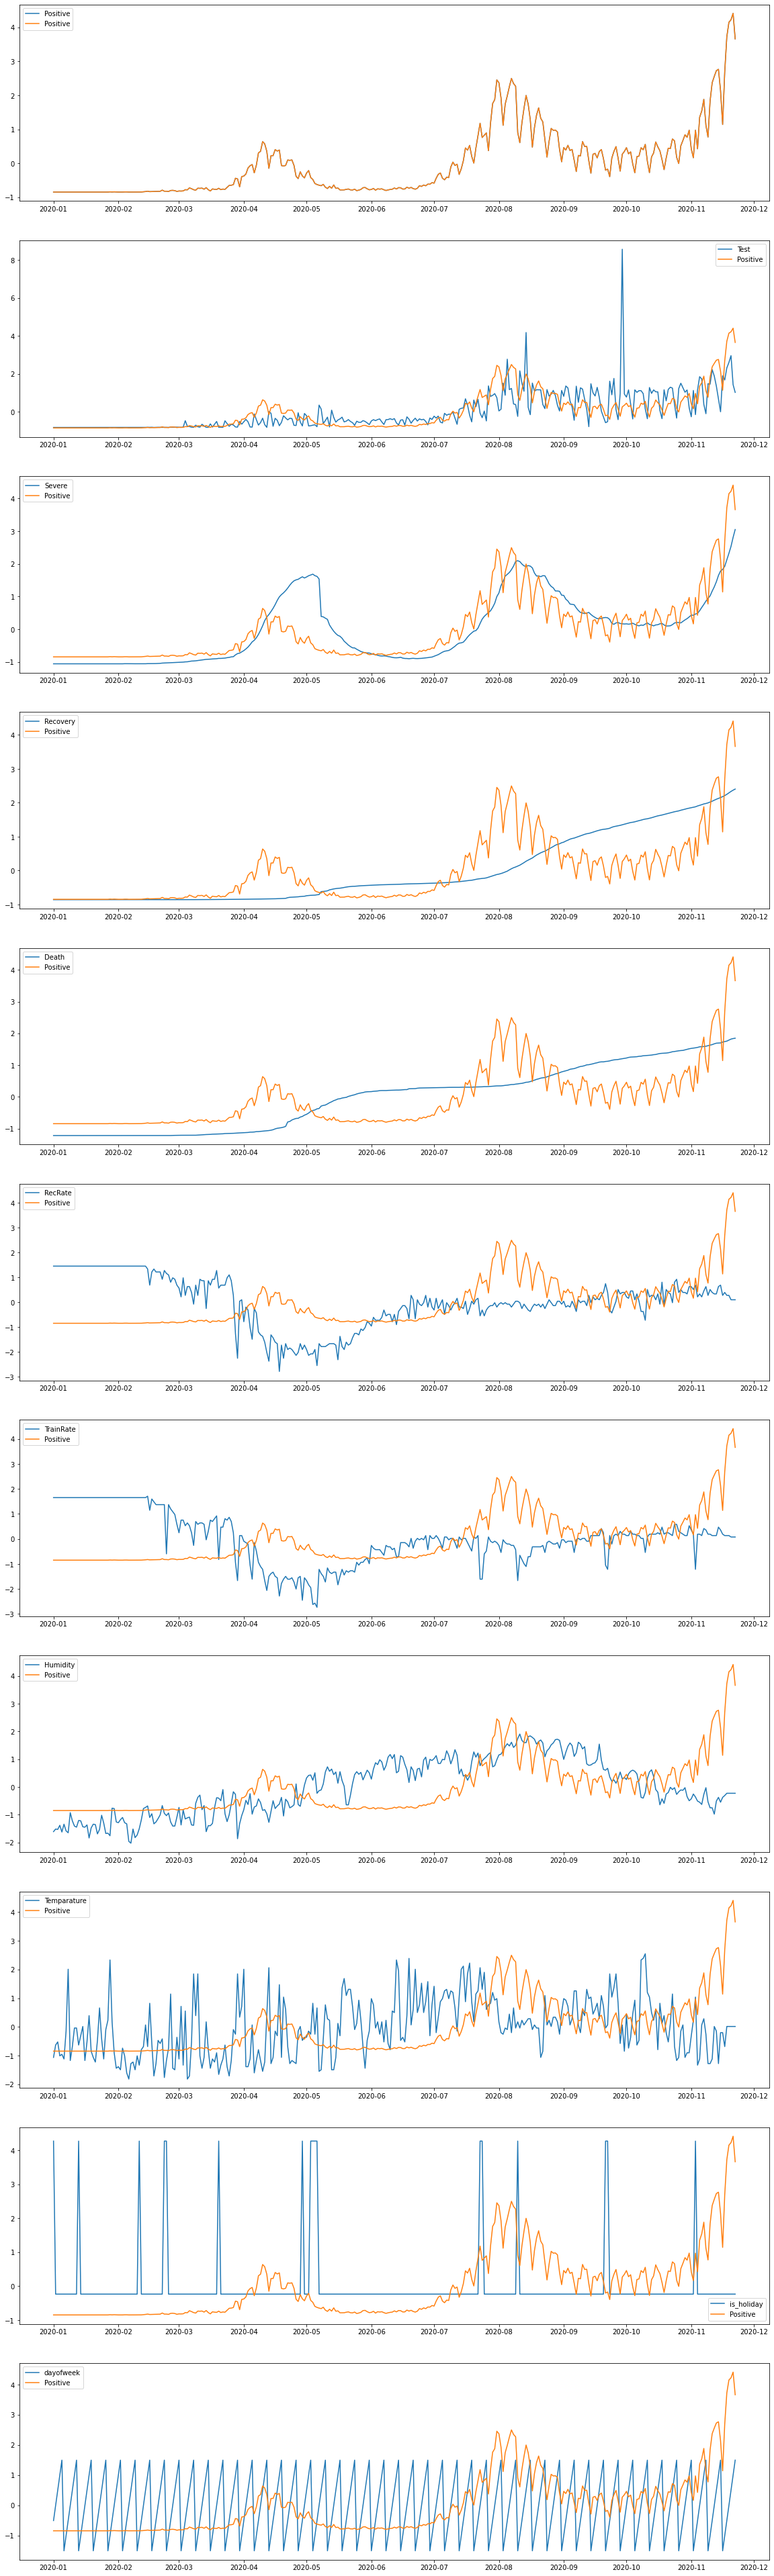

In [14]:
plt.figure(figsize=(20,70))
for ncol,colname in enumerate(df4.columns):
    plt.subplot(len(df4.columns),1,ncol+1)
    plt.plot(df4[colname])
    plt.plot(df4['Positive'])
    plt.legend(labels=[colname,'Positive'])

# pyCaret Regression

In [15]:
X_train = df7.iloc[:-45,:-1]
y_train = df7.iloc[:-45,-1]
X_test = df7.iloc[-45:,:-1]
y_test = df7.iloc[-45:,-1]

In [16]:
exp1 = setup(df7.iloc[:-45,:],'Positive')

,Description,Value
0,session_id,6566
1,Target,Positive
2,Original Data,"(267, 23)"
3,Missing Values,False
4,Numeric Features,20
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(186, 22)"


In [17]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,81.4833,15933.3542,120.5526,0.8858,0.3792,0.3666,0.6690
et,Extra Trees Regressor,81.4063,18367.6806,129.0378,0.8751,0.3198,0.3031,0.1480
gbr,Gradient Boosting Regressor,85.1075,19853.3261,133.0770,0.8301,0.3741,0.3155,0.0180
lightgbm,Light Gradient Boosting Machine,97.5970,22506.4324,144.3051,0.8299,0.4602,0.4223,0.0090
rf,Random Forest Regressor,98.0285,25381.5639,152.7085,0.8066,0.3266,0.3009,0.1650
ada,AdaBoost Regressor,129.8667,29868.4877,167.4097,0.8017,0.6935,0.9523,0.0200
knn,K Neighbors Regressor,124.9001,40097.0132,191.8128,0.7176,0.4777,0.4522,0.0260
en,Elastic Net,168.9010,46063.0408,211.6042,0.6971,0.7996,1.0611,0.0050
llar,Lasso Least Angle Regression,164.2303,47520.0339,213.5257,0.6947,0.7820,1.0268,0.1220
br,Bayesian Ridge,166.7609,47318.6638,214.1506,0.6827,0.7838,1.0050,0.0050


In [18]:
cat = create_model('catboost')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,60.8531,8437.7107,91.8570,0.9688,0.3640,0.2986
1,37.6936,3343.6046,57.8239,0.9776,0.3903,0.3519
2,99.6183,18646.8864,136.5536,0.8933,0.4017,0.3410
3,104.2684,23849.1287,154.4316,0.8689,0.3219,0.2826
4,84.0215,18201.6528,134.9135,0.6752,0.4441,0.4705
5,58.2116,6280.9397,79.2524,0.9451,0.3619,0.3377
6,89.9268,17739.7821,133.1908,0.8743,0.3206,0.3033
7,78.5818,13367.4292,115.6176,0.9136,0.1743,0.1529
8,84.2830,11403.9509,106.7893,0.9509,0.3290,0.3075
9,117.3744,38062.4570,195.0960,0.7904,0.6842,0.8205


In [19]:
leg = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,169.4237,57255.5586,239.2813,0.7882,0.7091,0.6788
1,159.7882,38203.0977,195.4561,0.7440,0.9837,2.2899
2,147.1756,40754.4219,201.8772,0.7667,0.5360,0.5451
3,208.7960,62567.8867,250.1357,0.6561,0.6865,0.6610
4,174.1747,50355.1992,224.3996,0.1013,1.1266,1.7989
5,117.8995,25662.8594,160.1963,0.7756,0.8083,1.2999
6,175.3652,56883.4062,238.5024,0.5971,0.8835,1.3766
7,156.6022,37021.2148,192.4090,0.7608,0.3952,0.3618
8,190.3249,54694.5703,233.8687,0.7645,0.8668,1.0701
9,184.9518,53433.6367,231.1572,0.7057,1.3374,1.7237


In [20]:
knn = create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,111.6105,24873.9766,157.7149,0.9080,0.3738,0.3394
1,92.8526,16835.2891,129.7509,0.8872,0.4990,0.4468
2,173.5579,51305.1758,226.5065,0.7063,0.6003,0.5534
3,103.0000,20476.4766,143.0960,0.8875,0.3947,0.3373
4,135.0737,37481.1953,193.6006,0.3311,0.6745,0.8590
5,73.6947,10737.9678,103.6242,0.9061,0.3857,0.3619
6,169.3222,96782.1797,311.0984,0.3145,0.6189,0.4554
7,131.9000,40362.1875,200.9034,0.7392,0.3697,0.3051
8,133.0889,49058.6641,221.4919,0.7888,0.3396,0.3063
9,124.9000,53057.0195,230.3411,0.7078,0.5212,0.5578


In [21]:
br = create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,200.4047,71436.5647,267.2762,0.7358,0.7397,0.8951
1,138.2047,26077.2110,161.4844,0.8252,0.9377,1.6707
2,144.6114,45935.1339,214.3248,0.7370,0.8243,0.4956
3,217.9878,69232.5890,263.1209,0.6195,0.6916,0.7395
4,168.4019,45274.2583,212.7775,0.1920,1.0509,1.0597
5,111.8305,22714.7766,150.7142,0.8014,0.8302,1.2413
6,164.8253,43170.5338,207.7752,0.6942,0.6640,0.7286
7,154.4031,39320.8504,198.2949,0.7459,0.3560,0.3271
8,208.2808,68056.2848,260.8760,0.7070,0.6671,0.8282
9,158.6585,41968.4353,204.8620,0.7689,1.0764,2.0643


In [22]:
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,81.4833,15933.3542,120.5526,0.8858,0.3792,0.3666,0.6570
et,Extra Trees Regressor,81.4063,18367.6806,129.0378,0.8751,0.3198,0.3031,0.1420
gbr,Gradient Boosting Regressor,85.1075,19853.3261,133.0770,0.8301,0.3741,0.3155,0.0190
lightgbm,Light Gradient Boosting Machine,97.5970,22506.4324,144.3051,0.8299,0.4602,0.4223,0.0100
rf,Random Forest Regressor,98.0285,25381.5639,152.7085,0.8066,0.3266,0.3009,0.1610
ada,AdaBoost Regressor,129.8667,29868.4877,167.4097,0.8017,0.6935,0.9523,0.0190
knn,K Neighbors Regressor,124.9001,40097.0132,191.8128,0.7176,0.4777,0.4522,0.0270
en,Elastic Net,168.9010,46063.0408,211.6042,0.6971,0.7996,1.0611,0.0050
llar,Lasso Least Angle Regression,164.2303,47520.0339,213.5257,0.6947,0.7820,1.0268,0.1190
br,Bayesian Ridge,166.7609,47318.6638,214.1506,0.6827,0.7838,1.0050,0.0050


In [23]:
ensemble = blend_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,62.4201,7300.3063,85.4418,0.9730,0.3298,0.2839
1,36.1456,3497.9647,59.1436,0.9766,0.4689,0.4452
2,92.7636,18537.0955,136.1510,0.8939,0.2942,0.2656
3,101.9104,26230.2388,161.9575,0.8558,0.2525,0.1999
4,78.7257,23654.7989,153.8012,0.5778,0.3490,0.3494
5,50.8634,4848.0476,69.6279,0.9576,0.2683,0.2324
6,93.9755,21565.5629,146.8522,0.8472,0.3046,0.2668
7,74.0665,11853.8408,108.8753,0.9234,0.1637,0.1400
8,87.6704,14203.5051,119.1785,0.9389,0.2907,0.2679
9,105.3380,35205.3068,187.6308,0.8061,0.5342,0.5765


In [24]:
stacking_leg = stack_models(top3,meta_model = leg)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,58.4617,7657.6946,87.5083,0.9717,0.4028,0.3781
1,61.8955,7008.0845,83.7143,0.9530,0.7798,0.6526
2,105.3359,15755.3799,125.5204,0.9098,0.3813,0.5437
3,105.0985,30615.6832,174.9734,0.8317,0.6916,0.2922
4,87.0035,31478.6237,177.4222,0.4382,0.4957,0.4519
5,76.9008,7899.6219,88.8798,0.9309,0.8158,0.7436
6,83.3318,16344.4597,127.8455,0.8842,0.5684,0.3021
7,75.3322,10778.1248,103.8177,0.9303,0.1999,0.1621
8,75.0948,8469.7755,92.0314,0.9635,0.5300,0.4803
9,109.0782,29239.4700,170.9955,0.8390,0.8670,1.0249


In [25]:
stacking = stack_models(top3,meta_model = br)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,52.7121,5691.3902,75.4413,0.9789,0.3180,0.2312
1,49.1609,4340.0677,65.8792,0.9709,0.5375,0.5242
2,93.7002,14307.2914,119.6131,0.9181,0.5981,0.4387
3,102.7672,29747.9101,172.4758,0.8365,0.2654,0.2139
4,82.9172,30183.4980,173.7340,0.4613,0.3288,0.3105
5,52.0697,4726.6107,68.7504,0.9587,0.3641,0.3046
6,84.9722,16692.3291,129.1988,0.8818,0.2753,0.2457
7,72.6334,10456.0670,102.2549,0.9324,0.1891,0.1445
8,80.4190,10333.5559,101.6541,0.9555,0.4130,0.2731
9,104.0627,31945.9014,178.7342,0.8241,0.5434,0.6464


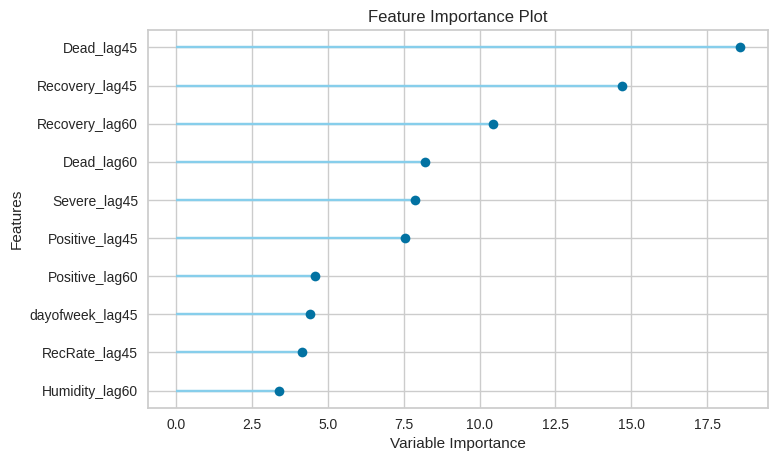

In [26]:
plot_model(cat,plot='feature')

In [27]:
cat_predicted = predict_model(cat)
ens_predicted = predict_model(ensemble)
stack_predicted = predict_model(stacking)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,150.7804,96166.9158,310.1079,0.7292,0.5335,0.3825


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,144.1945,91786.7809,302.9633,0.7416,0.3553,0.2788


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,140.3678,84231.5464,290.2267,0.7628,0.4499,0.3356


In [33]:
cat_pred = predict_model(cat,data=df7)
ens_pred = predict_model(ensemble,data=df7)
stack_pred = predict_model(stacking,data=df7)

In [34]:
cat_pred.to_csv('./pred/cat_pred60-45_'+ str(today)  + '.csv')
ens_pred.to_csv('./pred/ens_pred60-45_'+ str(today)  + '.csv')
stack_pred.to_csv('./pred/stack_pred60-45_'+ str(today)  + '.csv')

# Bokehでの可視化
https://qiita.com/Sampeipei/items/e5223e1452139a2ed142

In [35]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import column

In [36]:
cat_pred['date'] = cat_pred.index
ens_pred['date'] = ens_pred.index
stack_pred['date'] = stack_pred.index

source1 = ColumnDataSource(cat_pred)
source2 = ColumnDataSource(ens_pred)
source3 = ColumnDataSource(stack_pred)

bokeh_figure = figure(x_axis_type='datetime', plot_width=800,plot_height=400)

bokeh_figure.line(x='date',y='Positive',source=source1,color='green',legend_label='actual')
bokeh_figure.line(x='date',y='Label',source=source1,color='blue',legend_label='cat')
bokeh_figure.line(x='date',y='Label',source=source2,color='yellow',legend_label='top3')
bokeh_figure.line(x='date',y='Label',source=source3,color='red',legend_label='stacking')

output_notebook()
show(bokeh_figure)

Loading BokehJS ...

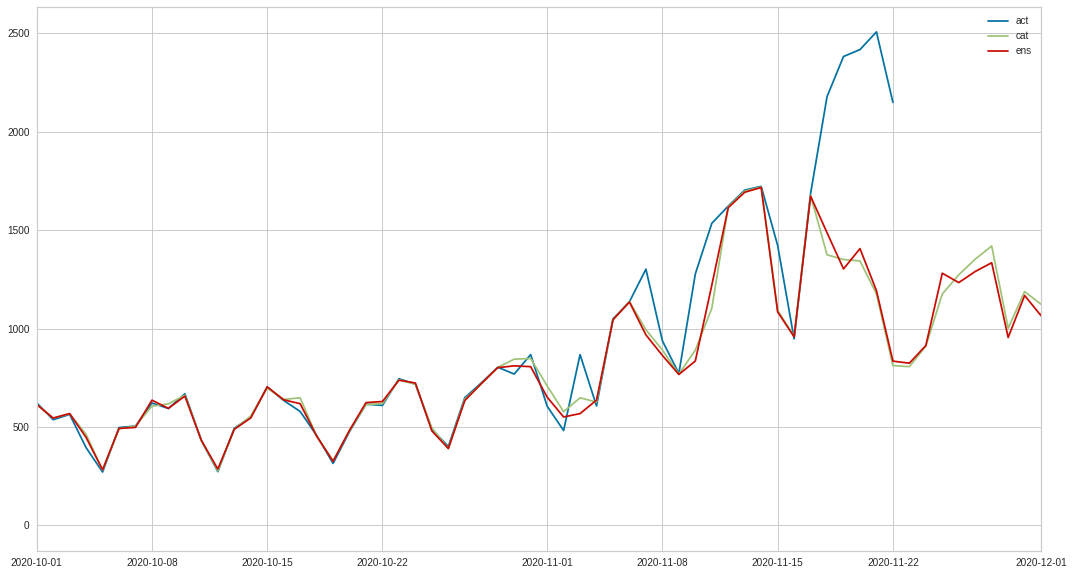

In [37]:
plt.figure(figsize=(18,10))
plt.plot(cat_pred['Positive'],label='act')
plt.plot(cat_pred['Label'],label='cat')
plt.plot(ens_pred['Label'],label ='ens')
#plt.plot(stack_pred['Label'],label='stack')

plt.xlim(datetime.datetime(2020,10,1),datetime.datetime(2020,12,1))
plt.legend()
#plt.savefig('./fig/model03_pred60dys_pycaret_'+str(today)+'.png')